# Statistical Analysis of Quechua Morphology and Corpus

Analyzes Zipf's law, Heaps' law, and Zipf-Mandelbrot fitting on Quechua data. Helps understand morpheme distributions and vocabulary growth patterns.

In [1]:
# Core libraries
import os
import ast
import math
import re
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

In [2]:
# Paths
DATA_FOLDER = "data"
FILE_PATH = os.path.join(DATA_FOLDER, "qu_merged_dump.txt")

# Tokenization options
lowercase = True
keep_apostrophes = True

# Analysis parameters
tail_ignore = 50
tail_min_len = 100
heaps_stride = 50
min_rank_for_fit = 1
max_rank_for_fit = None

estimated zipf exponent s (tail fit): 1.448


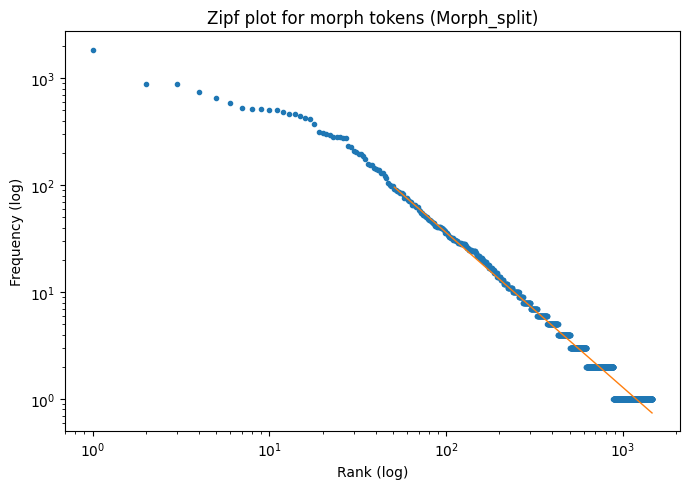

In [3]:
# Part 1: Zipf's law on morphological tokens

# Load gold standard data
df = pd.read_parquet(os.path.join(DATA_FOLDER, "Sue_kalt.parquet"))
df['Word'] = df['word']
df['morph'] = df['morph'].str.replace('-', ' ')
df['Morph_split_str'] = df['morph']
df['Morph_split'] = df['morph'].str.split(' ')
df = df[['Word', 'Morph_split', 'Morph_split_str']]

# Extract all morpheme tokens
tokens = []
for toks in df["Morph_split"]:
    tokens.extend(t for t in toks if isinstance(t, str) and t.strip() != "")

# Count frequencies
freq = Counter(tokens)
counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)

# Zipf plot for morphemes
ranks = np.arange(1, len(counts) + 1, dtype=np.int64)

plt.figure(figsize=(7, 5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=3)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf plot for morph tokens (Morph_split)")

# Fit line on tail to estimate exponent
k = min(50, len(counts) // 10 if len(counts) > 1000 else 10)
if len(counts) > k + 10:
    x = np.log(ranks[k:])
    y = np.log(counts[k:])
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    plt.loglog(ranks[k:], np.exp(y_fit), linewidth=1)

    s_est = -slope
    print(f"estimated zipf exponent s (tail fit): {s_est:.3f}")

plt.tight_layout()
plt.show()

file: data\qu_merged_dump.txt
total tokens: 2,100,201
vocabulary size: 206,316

top 25 tokens:
 1. mana	20920
 2. kay	20828
 3. chay	19580
 4. huk	19135
 5. nispa	16031
 6. diospa	14401
 7. nisqaqa	13149
 8. jehová	12300
 9. manan	11917
10. allin	10248
11. ichaqa	10122
12. mama	9935
13. llaqtapi	9566
14. hina	9294
15. ima	8440
16. chaymi	8351
17. karqan	8064
18. llaqta	7819
19. tukuy	7805
20. simipi	7597
21. ñiqin	7444
22. runa	6939
23. watapi	6923
24. killapi	6708
25. chayqa	6548


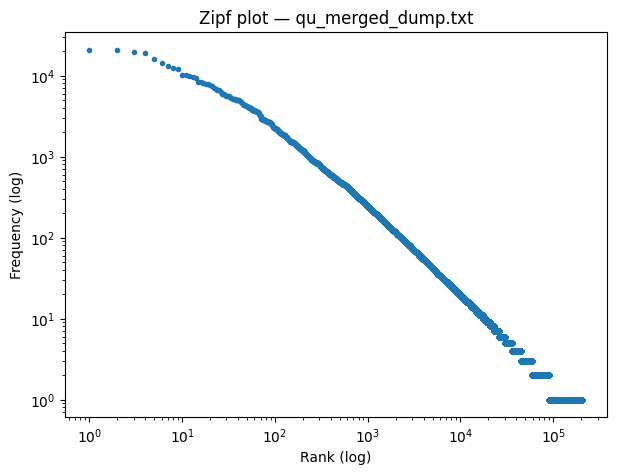

In [4]:
# Part 2: Corpus-level analysis

# Tokenizer
if keep_apostrophes:
    TOKEN_RE = re.compile(r"[^\W\d_]+(?:[''][^\W\d_]+)?", flags=re.UNICODE)
else:
    TOKEN_RE = re.compile(r"[^\W\d_]+", flags=re.UNICODE)

def iter_tokens_from_file(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if lowercase:
                line = line.lower()
            for m in TOKEN_RE.finditer(line):
                yield m.group(0)

# Count tokens in corpus
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"file not found: {FILE_PATH}")

freq = Counter()
for tok in iter_tokens_from_file(FILE_PATH):
    freq[tok] += 1

total_tokens = sum(freq.values())
vocab_size = len(freq)

print(f"file: {FILE_PATH}")
print(f"total tokens: {total_tokens:,}")
print(f"vocabulary size: {vocab_size:,}")

print("\ntop 25 tokens:")
for i, (tok, c) in enumerate(freq.most_common(25), 1):
    print(f"{i:>2}. {tok}\t{c}")

# Prepare for Zipf plot
counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)
ranks = np.arange(1, len(counts) + 1, dtype=np.int64)

# Zipf plot for corpus words
plt.figure(figsize=(7,5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=3)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf plot — " + os.path.basename(FILE_PATH))
plt.show()

In [5]:
# Part 3: Advanced statistical modeling

# Tokenizer (same as before)
if keep_apostrophes:
    TOKEN_RE = re.compile(r"[^\W\d_]+(?:[''][^\W\d_]+)?", flags=re.UNICODE)
else:
    TOKEN_RE = re.compile(r"[^\W\d_]+", flags=re.UNICODE)

def iter_tokens(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if lowercase:
                line = line.lower()
            for m in TOKEN_RE.finditer(line):
                yield m.group(0)

# Heaps' law: vocabulary growth
def vocab_growth(path, stride=50):
    """Track vocabulary growth as we process tokens."""
    seen = set()
    n_points, V_points = [], []
    n = 0
    for tok in iter_tokens(path):
        n += 1
        if tok not in seen:
            seen.add(tok)
        if (n % stride) == 0:
            n_points.append(n)
            V_points.append(len(seen))
    if not n_points or n_points[-1] != n:
        n_points.append(n)
        V_points.append(len(seen))
    return np.array(n_points, dtype=np.int64), np.array(V_points, dtype=np.int64)

def fit_heaps_logls(n, V, min_n=1000, tail_frac=0.7):
    """Fit Heaps' law: V(n) = K * n^β in log-space."""
    mask = n >= max(1, min_n)
    n_fit, V_fit = (n[mask], V[mask]) if mask.any() else (n, V)

    if 0 < tail_frac < 1.0:
        start = int((1 - tail_frac) * len(n_fit))
        n_fit = n_fit[start:]
        V_fit = V_fit[start:]

    x = np.log(n_fit)
    y = np.log(V_fit)
    slope, intercept = np.polyfit(x, y, 1)
    beta = slope
    K = np.exp(intercept)
    
    yhat = slope * x + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return beta, K, r2, (n_fit[0], n_fit[-1])

# Zipf-Mandelbrot fitting
def counts_from_file(path):
    """Count word frequencies and return sorted counts."""
    freq = Counter()
    for tok in iter_tokens(path):
        freq[tok] += 1
    counts = np.array(sorted(freq.values(), reverse=True), dtype=np.int64)
    return counts, freq

def fit_zipf_mandelbrot(counts, rmin=1, rmax=None):
    """Fit Zipf-Mandelbrot model: frequency(r) = C / (r + q)^s"""
    R = np.arange(1, len(counts) + 1, dtype=np.float64)
    if rmax is None or rmax > len(R): rmax = len(R)
    r_slice = slice(rmin-1, rmax)
    r = R[r_slice]
    c = counts[r_slice].astype(np.float64)

    log_r = np.log(r)

    def rmse_for(s, q):
        rq = r + q
        if np.any(rq <= 0):
            return np.inf, None
        log_rq = np.log(rq)
        logC = np.mean(np.log(c) + s * log_rq)
        logc_hat = logC - s * log_rq
        rmse = np.sqrt(np.mean((np.log(c) - logc_hat)**2))
        return rmse, logC

    # Coarse grid search
    s_grid = np.linspace(0.6, 1.6, 27)
    q_grid = np.concatenate([np.linspace(0.0, 20.0, 21),
                             np.linspace(25.0, 200.0, 8)])
    best = (np.inf, None, None, None)
    for s in s_grid:
        for q in q_grid:
            rmse, logC = rmse_for(s, q)
            if rmse < best[0]:
                best = (rmse, s, q, logC)

    rmse0, s0, q0, logC0 = best

    # Refined local search
    def refine(s_c, q_c, s_step=0.05, q_step=2.0, n_iter=6):
        best_rmse, best_s, best_q, best_logC = rmse0, s0, q0, logC0
        for _ in range(n_iter):
            improved = False
            for s in np.linspace(best_s - s_step, best_s + s_step, 7):
                for q in np.linspace(max(-0.9, best_q - q_step), best_q + q_step, 7):
                    rmse, logC = rmse_for(s, q)
                    if rmse < best_rmse:
                        best_rmse, best_s, best_q, best_logC = rmse, s, q, logC
                        improved = True
            s_step *= 0.5
            q_step *= 0.5
            if not improved:
                break
        return best_rmse, best_s, best_q, best_logC

    rmse, s, q, logC = refine(s0, q0)
    C = float(np.exp(logC))
    return s, q, C, rmse, (rmin, rmax)

In [6]:
# Execute Heaps' law analysis
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"file not found: {FILE_PATH}")

n_arr, V_arr = vocab_growth(FILE_PATH, stride=heaps_stride)
beta, K, r2, (n0, n1) = fit_heaps_logls(n_arr, V_arr, min_n=2000, tail_frac=0.7)

print("\n=== heaps' law ===")
print(f"β (slope): {beta:.4f}")
print(f"K: {K:.4f}")
print(f"R^2 (log–log fit): {r2:.4f}")
print(f"fit range n in [{n0}, {n1}]   total tokens seen ~ {n_arr[-1]}   vocab ~ {V_arr[-1]}")


=== heaps' law ===
β (slope): 0.9043
K: 0.3925
R^2 (log–log fit): 0.9785
fit range n in [631450, 2100201]   total tokens seen ~ 2100201   vocab ~ 206316


In [7]:
# Execute Zipf-Mandelbrot fitting
counts, freq = counts_from_file(FILE_PATH)
ranks = np.arange(1, len(counts)+1, dtype=np.int64)

rmin = max(1, min_rank_for_fit)
rmax = len(counts) if max_rank_for_fit is None else min(max_rank_for_fit, len(counts))
s, q, C, rmse_log, (rf0, rf1) = fit_zipf_mandelbrot(counts, rmin=rmin, rmax=rmax)

print("\n=== zipf–mandelbrot ===")
print(f"s: {s:.4f}")
print(f"q: {q:.4f}")
print(f"C: {C:.4e}")
print(f"RMSE in log-frequency (fit ranks [{rf0}, {rf1}]): {rmse_log:.4f}")


=== zipf–mandelbrot ===
s: 1.0615
q: 6.0000
C: 3.0518e+05
RMSE in log-frequency (fit ranks [1, 206316]): 0.2011


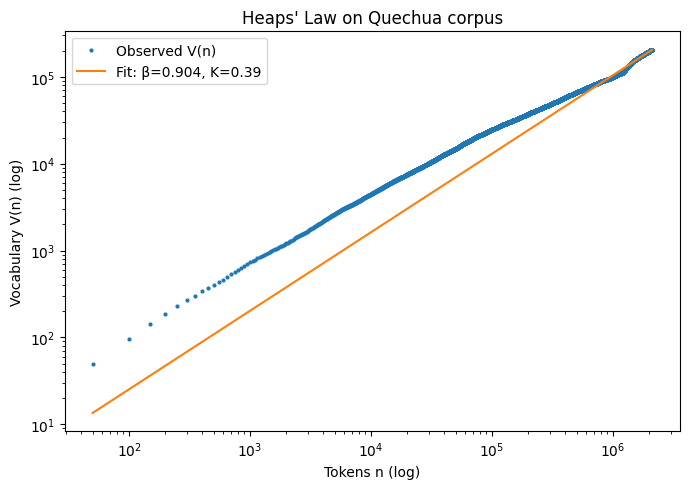

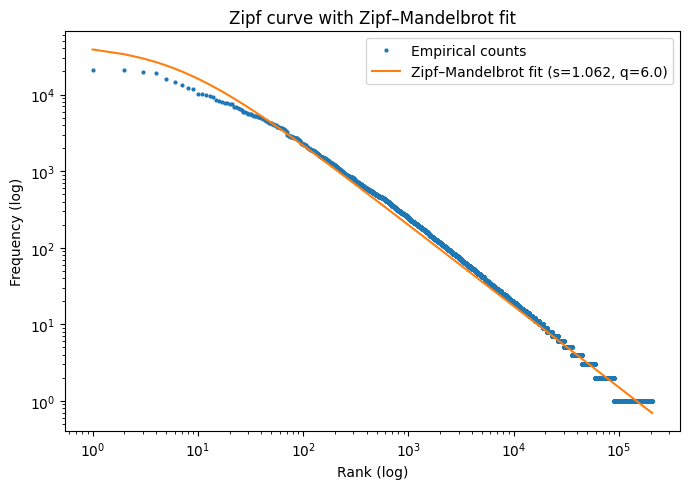

In [8]:
# Visualization plots

# Heaps' law plot
plt.figure(figsize=(7,5))
plt.loglog(n_arr, V_arr, marker='o', linestyle='none', markersize=2, label="Observed V(n)")
V_fit = K * (n_arr.astype(float) ** beta)
plt.loglog(n_arr, V_fit, linewidth=1.5, label=f"Fit: β={beta:.3f}, K={K:.2f}")
plt.xlabel("Tokens n (log)")
plt.ylabel("Vocabulary V(n) (log)")
plt.title("Heaps' Law on Quechua corpus")
plt.legend()
plt.tight_layout()
plt.show()

# Zipf curve with Zipf–Mandelbrot overlay
plt.figure(figsize=(7,5))
plt.loglog(ranks, counts, marker='o', linestyle='none', markersize=2, label="Empirical counts")
r = ranks.astype(float)
model = C / ((r + q) ** s)
plt.loglog(r, model, linewidth=1.5, label=f"Zipf–Mandelbrot fit (s={s:.3f}, q={q:.1f})")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipf curve with Zipf–Mandelbrot fit")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Rolling Heaps exponent analysis
win = 200

x = np.log(n_arr.astype(float))
y = np.log(V_arr.astype(float))

roll_beta = np.full_like(x, np.nan, dtype=float)
for i in range(win, len(x)):
    xs, ys = x[i-win:i], y[i-win:i]
    slope, _ = np.polyfit(xs, ys, 1)
    roll_beta[i] = slope

print("tail rolling β (last 5):", np.round(roll_beta[-5:], 3))

tail rolling β (last 5): [0.636 0.634 0.632 0.63  0.629]


In [10]:
# Optional: save results
# Uncomment to save analysis results

# Save Heaps' Law parameters
# heaps_results = {
#     'beta': float(beta),
#     'K': float(K),
#     'r2': float(r2),
#     'total_tokens': int(n_arr[-1]),
#     'vocab_size': int(V_arr[-1])
# }
# import json
# with open(os.path.join(DATA_FOLDER, 'heaps_law_results.json'), 'w') as f:
#     json.dump(heaps_results, f, indent=2)

# Save Zipf-Mandelbrot parameters
# zipf_mandelbrot_results = {
#     's': float(s),
#     'q': float(q),
#     'C': float(C),
#     'rmse_log': float(rmse_log),
#     'rank_range': [int(rf0), int(rf1)]
# }
# with open(os.path.join(DATA_FOLDER, 'zipf_mandelbrot_results.json'), 'w') as f:
#     json.dump(zipf_mandelbrot_results, f, indent=2)

# Save vocabulary growth data
# vocab_growth_df = pd.DataFrame({
#     'token_count': n_arr,
#     'vocab_size': V_arr
# })
# vocab_growth_df.to_csv(os.path.join(DATA_FOLDER, 'vocab_growth_heaps.csv'), index=False)

# Save word frequency distribution
# freq_df = pd.DataFrame({
#     'word': list(freq.keys()),
#     'frequency': list(freq.values())
# })
# freq_df = freq_df.sort_values('frequency', ascending=False)
# freq_df.to_csv(os.path.join(DATA_FOLDER, 'word_frequencies.csv'), index=False)